<a href="https://colab.research.google.com/github/djdunc/casa0018/blob/main/Week6/CASA0018_6_2_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Time Series Forecasting with Recurrent Neural Networks**


This tutorial explores how to code simple Recurrent Neural Networks, both vanilla and LSTM, using the tensorflow libraries and test them against a trivial data set.

The tutorial leans heavily on the following source:

https://medium.com/towards-artificial-intelligence/beginners-guide-to-timeseries-forecasting-with-lstms-using-tensorflow-and-keras-364ea291909b

# Set Up

First set up the necessary Python imports.

In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM
from tensorflow.keras.callbacks import EarlyStopping


# Set Seeds

Attempt to make the data reproduceable from run to run.

In [15]:
# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)
#tf.compat.v1.random.set_random_seed(1234)

# Create Data

Create sine function data. We’ll use the NumPy linspace to generate x values ranging between 0 and 100 and NumPy sine function to generate sine values to the corresponding x. We also add a linear componenent to the sine data to generate a trend. 

We then add some noise to the data. Finally, let’s visualize the data.

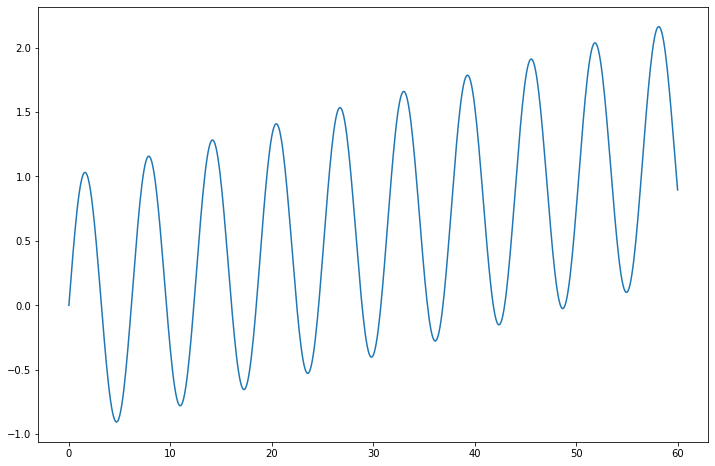

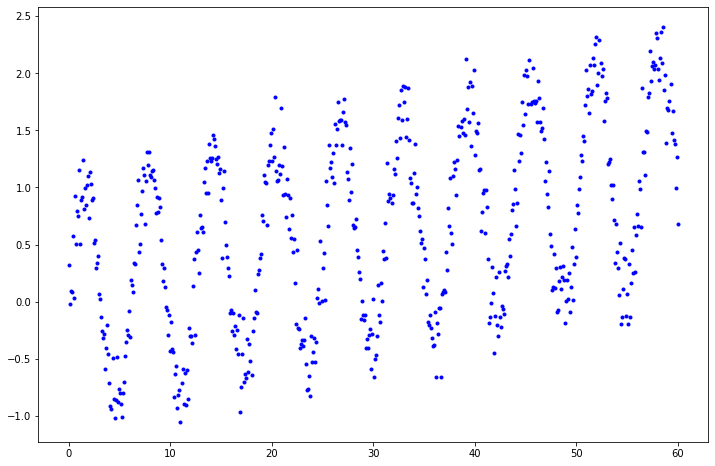

In [16]:
x = np.linspace(0, 60, 601)  # in radians
y = np.sin(x) + 0.02*x

# Plot our data
plt.figure(figsize=(12,8))
plt.plot(x,y)
plt.show()

y += 0.2*np.random.randn(*y.shape) #Add some noise to the data to make it more realistic

# Plot our data
plt.figure(figsize=(12,8))
plt.plot(x, y, 'b.')
plt.show()

# Define a dataframe using x and y values.
df = pd.DataFrame(data=y,index=x,columns=['Sine'])


# Split Data
Split the data into train and validate (10%) subsets. Rather than splitting the data into train and test dataset using traditional train_test_split function from sklearn, here we’ll split the dataset using simple python libraries to better understand the process going under the hood.

First, we’ll check the length of the data frame and use 10 percent of the training data to validate our model. Now if we multiply the length of the data frame with test_percent and round the value (as we are using for indexing purpose) we’ll get the index position i.e., test_index. Last, we’ll split the train and test data using the test_index.

For simplicity the validation set is referred to as 'test', but remember it is actually used for validation of the model.

601
501
100


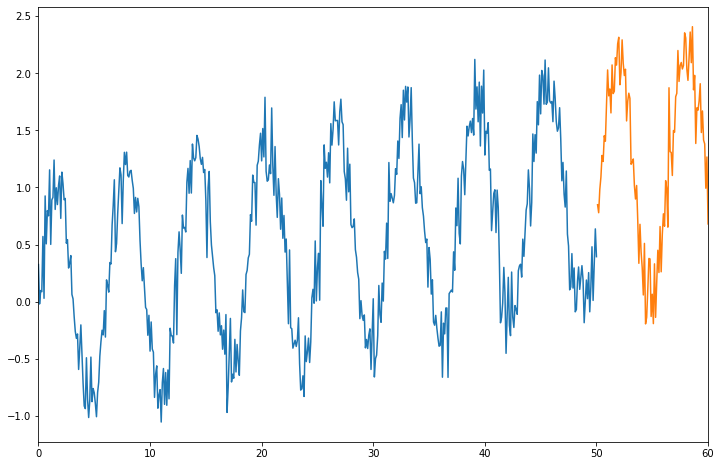

In [17]:
test_pecent = 0.16667 # 10 percent of data
len(df)*test_pecent # 
test_point = np.round(len(df)*test_pecent) 
test_index = int(len(df) - test_point) 
train = df.iloc[:test_index]
test = df.iloc[test_index:]

plt.figure(figsize=(12,8))
plt.xlim(0, 60)

print(len(df)) # 601
print(len(train))
print(len(test))
#train.plot()
#test.plot()
plt.plot(train)
plt.plot(test)


# Normalise
We need to normalise the data in the range 0-1. We use a scaler to determine the max and min of the training set and then use the scale to scale both the training a validation data set

In [18]:
scaler = MinMaxScaler()
scaler.fit(train)
MinMaxScaler(copy=True, feature_range=(0, 1))
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator
One problem we’ll face when using time series data is, we must transform the data into sequences of samples with input data and target data before feeding it into the model. We should select the length of the sequence data (window length) in such a way so that the model has an adequate amount of input data to generalize and predict i.e. in this situation we must feed the model at least with one cycle of sine wave values.

The model takes the previous 50 data points (one cycle) as input data and uses it to predict the next point, which is then compared to the actual target value for backpropagation and gradient descent. This process is time-consuming and difficult if we perform this manually, hence we’ll make use of the Keras Timeseries Generator which transforms the data automatically and ready to train models without heavy lifting.

We can see that the length of the scaled_train is 501 and the length of the generator is 451(501–50) i.e. if we perform the tuple unpacking of the generator function using X,y as variables, X comprises the 50 data points (training window) and y contains the 51st data point which the model uses for the prediction target. i.e. X0 = values at timesteps 0-49 and y0 = value at timestep 50; X1 = values at timesteps 1-50 and y1 = value at timestep 51; ... X451 = values at timesteps 451-500 and y451 = value at timestep 501.


We also create a validation_generator that operates on the validation data set (scaled_test in the code). The validator_generator is not used to train the model. Instead, it is used after each epoch to validate how well the current model fits an **unseen** data set.

In [19]:
length = 50 # sequence length - the length of the training window
batch_size = 10

generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=length, batch_size=batch_size)

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

print(len(scaled_train)) # 501
print(len(generator)) # 451

501
46


# Create a model and train it
The code to create a RNN is similar to that for earlier NNs you have already seen, although here we use a SimpleRNN layer.

The variable (n_features) defined stands for the number of features in the training data i.e., as we are dealing with univariate data we’ll only have one feature whereas if we are using multivariate data containing multiple features then we must specify the count of features in our data.

early_stop is a callback that stops the training if the validation loss fails to decrease over a number of epochs specified by the patience value (15).

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
n_features = 1
rnn_model = Sequential()
output_space = length # Same as number of time steps in the training window
rnn_model.add(SimpleRNN(output_space, return_sequences=False, input_shape = (length, n_features)))
#rnn_model.add(SimpleRNN(output_space))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(generator, epochs=100, validation_data=validation_generator, callbacks=[early_stop])
rnn_model.summary()

Epoch 1/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0614 - val_loss: 0.0120
Epoch 2/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0156 - val_loss: 0.0084
Epoch 3/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0089 - val_loss: 0.0139
Epoch 4/100
46/46 [==============================] - 0s 11ms/step - loss: 0.0066 - val_loss: 0.0137
Epoch 5/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0067 - val_loss: 0.0104
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 7/100
46/46 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0144
Epoch 8/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0129
Epoch 9/100
46/46 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0102
Epoch 10/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0055 - val_loss: 0.0087


# Predict Next Value
Let’s test our model using first_eval_batch. The first_eval_batch contains the last 50 points of the scaled training data and uses these to make a prediction. The results of the predicted value and the first observation in the scaled_data is commented below for understanding. Our model predicts the next point as 0.567 whereas the original value is 0.599. 

In [21]:
first_eval_batch = scaled_train[-length:] # Take the last 50 points and predict the new value in the scaled_test
first_eval_batch = first_eval_batch.reshape((1, length, n_features)) # shape the data to match the input_shape of model
print(rnn_model.predict(first_eval_batch))
print(scaled_test[0])

[[0.5319213]]
[0.59931547]


# Forecasting Using The Validation Data
We can automate this processing of generating batches of data for evaluation from validation data. We’ll define a function that does the heavy lifting for us.

First, we’ll define an empty list (test_predictions) so we can append the predicted values. The second step is to define (first_eval_batch) i.e., the first evaluation batch that needs to be sent into the model and reshape the batch so it matches the input shape of our model. Our current_batch contains all the last 50 values from the training data.

Finally, we’ll define a loop that continues until it reaches the end of the test data. The predicted value gets appended to the (current_batch) and the first observation in the current_batch gets removed. i.e., our current_batch contains 50 values of which 49 are from the training data and 50th value is the model predicted value which gets appended.

You should be aware that this is not a true test as the validation data set was used to determine early stopping in other words the model was trained to minimise loss against the validation data set.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


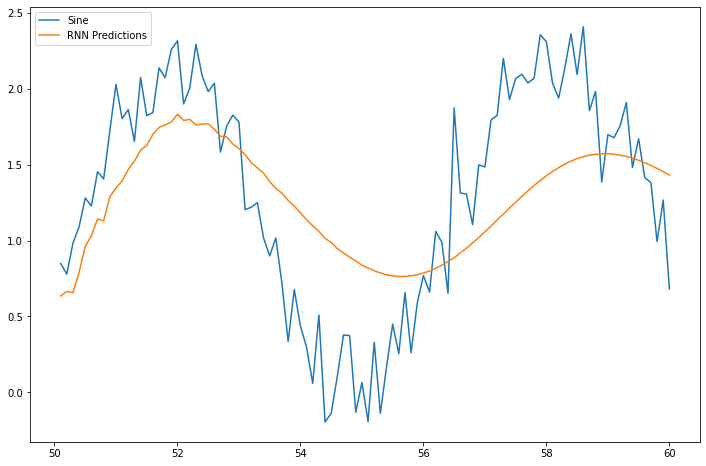

In [22]:
test_predictions = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape(1, length, n_features)


for i in range(len(test)):
  current_pred = rnn_model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

true_predictions = scaler.inverse_transform(test_predictions)
test['RNN Predictions'] = true_predictions
test.plot(figsize=(12,8))



There is almost negligible difference between the predicted value and the original sine wave value at the beginning as the first batch we sent for our model evaluation comprises the last 50 values from training data however as the loop continues the predicted values get appended to the batch that is fed into the model which causes a progressive deviation of the predicted curve from the true values.


----------------------------------------------------------------------------------------------------------------------------------------------------------------


# Long Short-Term Memory (LSTM) Neural Networks

Consider speech recognition. In speech recognition context is important, which requires the network to have some memory. For example consider the phrase “The sky is blue”. The context (“sky”) helps recognise the word “blue”.

Now consider another example: “The field was filled with cows who seemed very happy as they ate the grass”. We are trying to identify the word "grass", but the clues ("field", "cows") are earlier in the phrase. The further back in time the context information is positioned, the more challenging the problem is and the longer term memory is required.

LSTM have longer memory compared to vanilla RNNs. Thus LSTMs are perfect for speech recognition tasks or tasks where we have to deal with time-series data and longer term time dependencies are important.

Let's apply a LSTM to our sine data. The code for the network is similar to the vanilla RNN, except we use a LSTM layer instead of SimpleRNN layer.

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

length = 50
batch_size = 10

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

lstm_model = Sequential()

output_space = length # Same as number of time steps in the training window

lstm_model.add(LSTM(output_space, return_sequences=False, input_shape=(length, n_features)))
#lstm_model.add(LSTM(output_space))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer = 'adam', loss='mse')

lstm_model.fit(generator, epochs=100, validation_data=validation_generator, callbacks=[early_stop])

lstm_model.summary()


Epoch 1/100
46/46 [==============================] - 1s 31ms/step - loss: 0.0708 - val_loss: 0.0349
Epoch 2/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0217 - val_loss: 0.0168
Epoch 3/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0127 - val_loss: 0.0089
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 0.0089 - val_loss: 0.0096
Epoch 5/100
46/46 [==============================] - 1s 21ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 6/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0062 - val_loss: 0.0104
Epoch 7/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0056 - val_loss: 0.0065
Epoch 8/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0053 - val_loss: 0.0139
Epoch 9/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0055 - val_loss: 0.0087
Epoch 10/100
46/46 [==============================] - 1s 22ms/step - loss: 0.0054 - val_loss: 0.0079

# Comparing Forecasts Using The Validation Data

Now let's compare the forecasts of the RNN and LSTM models using our validation data set.

Again remembering this is not a true test as the validation set was used to validate our models.

Before we plot the results we reverse the scaling transformations.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


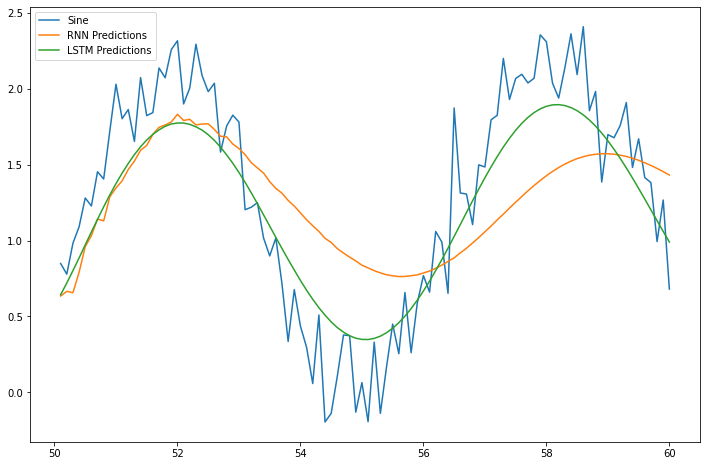

In [24]:
test_predictions = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape(1,length,n_features)


for i in range(len(test)):
  current_pred = lstm_model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)

true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

# Forecasting into the future

Now let's look into the future, beyond our current data set. Normally, we would compare the results against our test data set that has never been seen by the network. However, as the current series is easily predictable we will rely on visual inspection. This is the first "true" test.

Strictly speaking we should retrain both our models using the full data set (training + validation data). But to save time we use our current models.

We forecast values into the future for time running from 60.1 to 65.1 for time steps of 0.1

In [25]:
full_scaler = MinMaxScaler()

scaled_full_data = full_scaler.fit_transform(df)

forecast_rnn = []
forecast_lstm = []


first_eval_batch = scaled_full_data[-length:]

current_batch_rnn = first_eval_batch.reshape(1, length, n_features)
current_batch_lstm = first_eval_batch.reshape(1, length, n_features)


for i in range(50):
  current_pred_rnn = rnn_model.predict(current_batch_rnn)[0]
  current_pred_lstm = lstm_model.predict(current_batch_lstm)[0]

  forecast_rnn.append(current_pred_rnn)
  forecast_lstm.append(current_pred_lstm)

  current_batch_rnn = np.append(current_batch_rnn[:,1:,:], [[current_pred_rnn]], axis = 1)
  current_batch_lstm = np.append(current_batch_lstm[:,1:,:], [[current_pred_lstm]], axis = 1)


# Plot the Forecasted values

To plot the result we first need to reverse the scaling transformation.

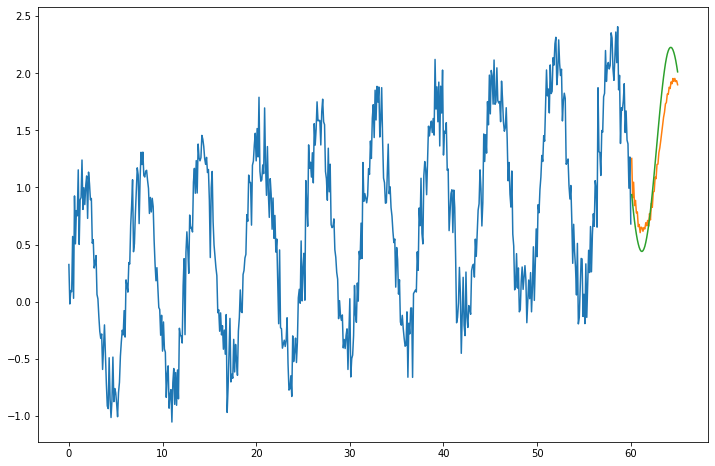

In [26]:
forecast_rnn = full_scaler.inverse_transform(forecast_rnn)
forecast_lstm = full_scaler.inverse_transform(forecast_lstm)

forecast_index = np.arange(60.1, 65.1, step=0.1)

plt.figure(figsize=(12,8))
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index, forecast_rnn)
plt.plot(forecast_index, forecast_lstm)
plt.show()
